In [78]:
import tensorflow as tf

In [59]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Paramemters

In [60]:
epochs = 16
lr = 0.001

## Dataset

In [66]:
batch_size = 256

(mnist_images, mnist_labels), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data(path='mnist.npz')

print(mnist_images.shape, mnist_labels.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [69]:
dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis] / 255.0, tf.float32),
             tf.cast(mnist_labels, tf.int64))
)
test_dset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(x_test[..., tf.newaxis] / 255.0, tf.float32),
             tf.cast(y_test, tf.int64))
)

nsamples = len(list(dataset))
ntests = len(list(test_dset))

dataset = dataset.repeat().shuffle(10000).batch(batch_size)
test_dset  = test_dset.repeat().batch(batch_size)

(256, 28, 28, 1) (256,)


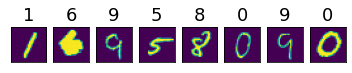

In [70]:
import matplotlib.pylab as plt
for x, y in dataset.take(1):
    print(x.shape, y.shape)
    for i in range(8):    
        plt.subplot(181+i)
        plt.imshow(x[i].numpy())
        plt.xticks([]);plt.yticks([])
        plt.title(y[i].numpy(), fontsize=18)
plt.show()

## Model

In [71]:
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, [3, 3], activation='relu'),
    tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

loss = tf.losses.SparseCategoricalCrossentropy()

opt = tf.optimizers.Adam(lr)

checkpoint_dir = './checkpoints/tf2_mnist'

checkpoint = tf.train.Checkpoint(model=mnist_model, optimizer=opt)


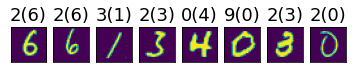

In [72]:
for x, y in dataset.take(1):
    probs = mnist_model(x)
    pred = tf.math.argmax(probs, axis=1)
    for i in range(8):    
        plt.subplot(181+i)
        plt.imshow(x[i].numpy())
        plt.xticks([]);plt.yticks([])
        plt.title("%s(%s)"%(pred[i].numpy(),y[i].numpy()), fontsize=18)
plt.show()

## Training 

In [73]:
@tf.function
def training_step(images, labels):
    with tf.GradientTape() as tape:
        probs = mnist_model(images, training=True)
        loss_value = loss(labels, probs)
        pred = tf.math.argmax(probs, axis=1)
        equality = tf.math.equal(pred, labels)
        accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    opt.apply_gradients(zip(grads, mnist_model.trainable_variables))
    return loss_value, accuracy

@tf.function
def validation_step(images, labels):
    probs = mnist_model(images, training=False)
    pred = tf.math.argmax(probs, axis=1)
    equality = tf.math.equal(pred, labels)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
    loss_value = loss(labels, probs)
    return loss_value, accuracy

In [74]:
nstep = nsamples//batch_size
ntest_step = ntests//batch_size

print("Number of training step: %d" %nstep)
print("Number of validation step: %d"%ntest_step)

Number of training step: 234
Number of validation step: 39


In [75]:
import time
t0 = time.time()

metrics={}
metrics['train_acc'] = []
metrics['valid_acc'] = []
metrics['train_loss'] = []
metrics['valid_loss'] = []

for ep in range(epochs):
    training_loss = 0.0
    training_acc = 0.0
    tt0 = time.time()
    for batch, (images, labels) in enumerate(dataset.take(nstep)):
        loss_value, acc = training_step(images, labels)
        training_loss += loss_value/nstep
        training_acc += acc/nstep
        if batch % 100 == 0:
            checkpoint.save(checkpoint_dir)
            print('Epoch - %d, step #%06d/%06d\tLoss: %.6f' % (ep, batch, nstep, loss_value))
    # Testing                                                                                                                                    
    test_acc = 0.0
    test_loss = 0.0
    for batch, (images, labels) in enumerate(test_dset.take(ntest_step)):
        loss_value, acc = validation_step(images, labels)
        test_acc += acc/ntest_step
        test_loss += loss_value/ntest_step
    tt1 = time.time()
    print('Epoch - %d, train Loss: %.6f, train Acc: %.6f, val loss: %.6f, val Acc: %.6f %.6f seconds' % (ep, training_loss,\
 training_acc, test_loss, test_acc, tt1 - tt0))
    metrics['train_acc'].append(training_acc)
    metrics['train_loss'].append(training_loss)
    metrics['valid_acc'].append(test_acc)
    metrics['valid_loss'].append(test_loss)
checkpoint.save(checkpoint_dir)
t1 = time.time()
print("Total training time: %s seconds" %(t1 - t0))

Epoch - 0, step #000000/000234	Loss: 2.304260
Epoch - 0, step #000100/000234	Loss: 0.196073
Epoch - 0, step #000200/000234	Loss: 0.132165
Epoch - 0, train Loss: 0.294695, train Acc: 0.911359, val loss: 0.059218, val Acc: 0.981971 1.182860 seconds
Epoch - 1, step #000000/000234	Loss: 0.094393
Epoch - 1, step #000100/000234	Loss: 0.097680
Epoch - 1, step #000200/000234	Loss: 0.069722
Epoch - 1, train Loss: 0.093245, train Acc: 0.971988, val loss: 0.043565, val Acc: 0.985878 0.817404 seconds
Epoch - 2, step #000000/000234	Loss: 0.033488
Epoch - 2, step #000100/000234	Loss: 0.064765
Epoch - 2, step #000200/000234	Loss: 0.081487
Epoch - 2, train Loss: 0.069103, train Acc: 0.979833, val loss: 0.036781, val Acc: 0.987180 0.812901 seconds
Epoch - 3, step #000000/000234	Loss: 0.027600
Epoch - 3, step #000100/000234	Loss: 0.137792
Epoch - 3, step #000200/000234	Loss: 0.043420
Epoch - 3, train Loss: 0.053468, train Acc: 0.983439, val loss: 0.031803, val Acc: 0.989183 0.820854 seconds
Epoch - 4, s

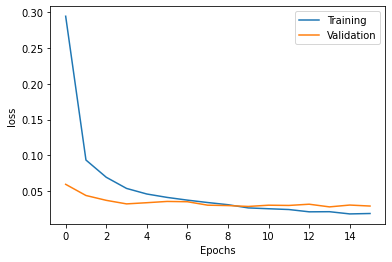

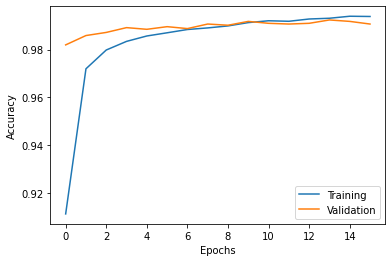

In [76]:
import matplotlib.pylab as plt
plt.plot(metrics['train_loss'], label='Training')
plt.plot(metrics['valid_loss'], label="Validation")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

import matplotlib.pylab as plt
plt.plot(metrics['train_acc'], label='Training')
plt.plot(metrics['valid_acc'], label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

(256, 28, 28, 1) (256,)


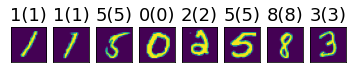

In [77]:
import matplotlib.pylab as plt
for x, y in dataset.take(1):
    print(x.shape, y.shape)
    probs = mnist_model(x)
    pred = tf.math.argmax(probs, axis=1)
    for i in range(8):    
        plt.subplot(181+i)
        plt.imshow(x[i].numpy())
        plt.xticks([]);plt.yticks([])
        plt.title("%s(%s)"%(pred[i].numpy(),y[i].numpy()), fontsize=18)
plt.show()